<a href="https://colab.research.google.com/github/gomdoori/AI/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
image_sz = 64

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

In [ ]:
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
nz = 128 # 잠재 벡터의 크기

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(

            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),

            nn.Linear(2048, 4096),
            nn.LeakyReLU(0.2),

            nn.Linear(4096, 4096), # 4096 = 64*64
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1,1,64,64)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_input = 4096
    self.main = nn.Sequential(

        nn.Linear(self.n_input, 4096),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(4096, 2048),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(2048, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(-1, 4096)
    return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=2048, out_features=4096, bias=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Linear(in_features=4096, out_features=4096, bias=True)
    (11): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=4096, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=2048, out_features=1

In [ ]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [ ]:
def train_discriminator(optimizer, data_real, data_fake):
  b_size = data_real.size(0) # 데이터 배치 크기
  real_label = torch.ones(b_size, 1).to(device)
  fake_label = torch.zeros(b_size, 1).to(device)
  optimizer.zero_grad()

  output_real = discriminator(data_real)
  loss_real = criterion(output_real, real_label)
  output_fake = discriminator(data_fake)
  loss_fake = criterion(output_fake, fake_label)
  loss_total = (loss_real + loss_fake) / 2
  loss_total.backward()
  optimizer.step()
  return loss_total

In [ ]:
def train_generator(optimizer, data_fake):
  b_size = data_fake.size(0)
  real_label = torch.ones(b_size, 1).to(device)
  optimizer.zero_grad()
  output = discriminator(data_fake)
  loss = criterion(output, real_label)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
from torchvision.utils import save_image

In [ ]:
epochs = 10
for epoch in range(epochs):
  loss_g = 0.0
  loss_d = 0.0
  for idx, data in enumerate(train_loader):
    image, _ = data
    data_real = image.to(device)
    b_size = len(data_real)

    data_fake = generator(torch.randn(b_size, nz).to(device))
    loss_d += train_discriminator(optim_d, data_real, data_fake)

    data_fake = generator(torch.randn(b_size, nz).to(device))
    loss_g += train_generator(optim_g, data_fake)

  epoch_loss_g = loss_g / idx
  epoch_loss_d = loss_d / idx
  losses_g.append(epoch_loss_g)
  losses_d.append(epoch_loss_d)
  if epoch%20==0:
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 10
Generator loss: 2.11306119, Discriminator loss: 0.41218117


In [ ]:
save_image(data_fake, 'result_fake.png', nrow=10, normalize=True)

In [ ]:
save_image(data_real, 'result_real.png', nrow=10, normalize=True)

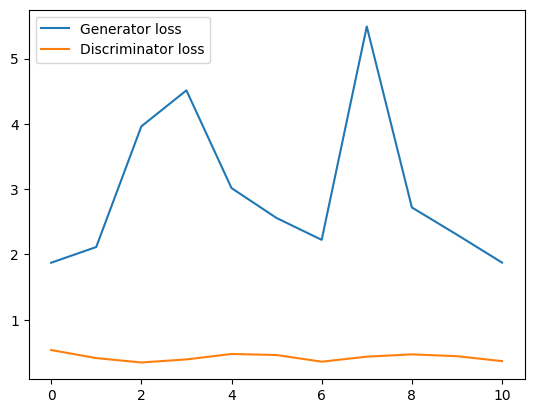

In [ ]:
plt.figure()
plt.plot(torch.Tensor(losses_g), label='Generator loss')
plt.plot(torch.Tensor(losses_d), label='Discriminator loss')
plt.legend()

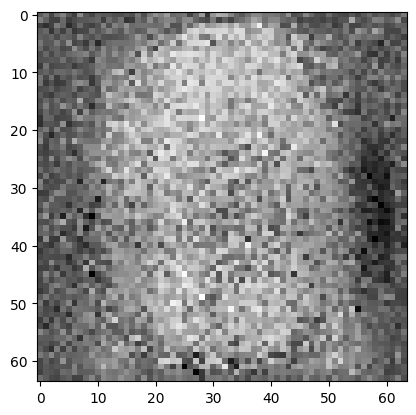

In [ ]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(1):
  fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (64,64))
  plt.imshow(fake_images_img, cmap = 'gray')
  plt.show()

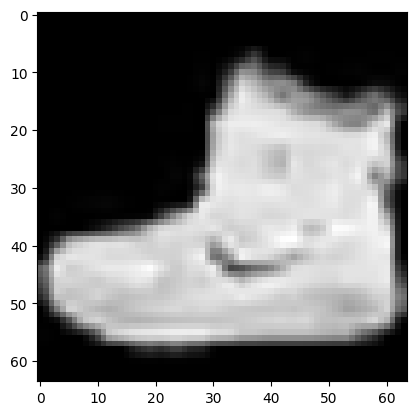

In [ ]:
for i in range(1):
  image, label = train_dataset[i]
  plt.imshow(np.transpose(image,(1,2,0)), cmap = 'gray')
  plt.show()